In [188]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pprint

In [189]:
h08dir = '/home/kajiyama/H08/H08_20230612'
SUF = '.gl5'
path = h08dir + '/map/out/riv_num_/rivnum.CAMA' + SUF
dtype = 'float32'
gl5shape = (2160, 4320)

In [190]:
maskpath = h08dir + '/map/dat/lnd_msk_/lndmask.CAMA.gl5'

In [191]:
rivnum = np.fromfile(path, dtype=dtype)

In [192]:
rivnum_lonlat = rivnum.reshape(gl5shape)

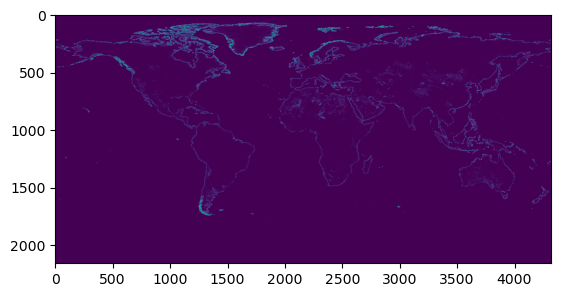

In [193]:
plt.imshow(rivnum_lonlat)

In [231]:
# tokyo region
# "138 141 34 38"
one = 138
two = 141
three = 34
four = 38
upperindex = (90-four)*12
lowerindex = (90-three)*12
leftindex = (180+one)*12
rightindex = (180+two)*12
print(upperindex, lowerindex, leftindex, rightindex)
rivnum_cropped = rivnum_lonlat[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]

624 672 3816 3852


In [232]:
#pprint.pprint(rivnum_cropped)

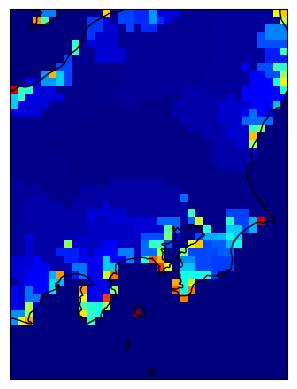

In [248]:
projection = ccrs.PlateCarree(central_longitude=0)
img_extent = (one, two, three, four)
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.coastlines()
im = ax.imshow(rivnum_cropped, extent=img_extent, transform=projection, cmap='jet')

In [249]:
print(upperindex, lowerindex, leftindex, rightindex)
citymask = np.fromfile('/home/kajiyama/H08/H08_20230612/map/dat/cty_msk_/city_00000001.gl5', dtype=dtype).reshape(gl5shape)
citymask_cropped = citymask[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]

624 672 3816 3852


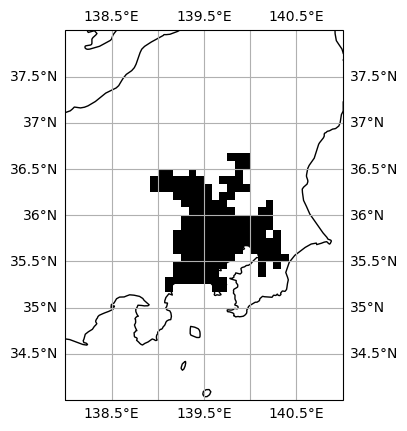

In [250]:
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.coastlines()
ax.gridlines(draw_labels=True)
im = ax.imshow(citymask_cropped, extent=img_extent, transform=projection, cmap='gray_r')

In [253]:
rivara_path = h08dir + '/map/out/riv_ara_/rivara.CAMA.gl5'
rivara = np.fromfile(rivara_path, dtype=dtype).reshape(gl5shape)
rivara_masked = np.ma.masked_where(rivara >=1e20, rivara)
rivara_cropped = rivara_masked[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]

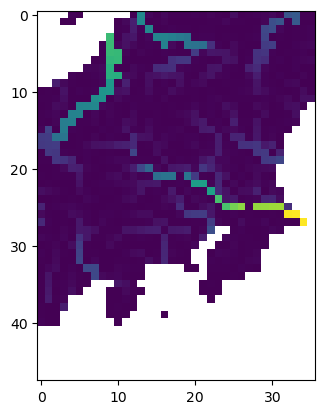

In [254]:
plt.imshow(rivara_cropped)

In [278]:
rivnum_tokyo_a = np.where(citymask_cropped == 1, rivnum_cropped, np.nan)

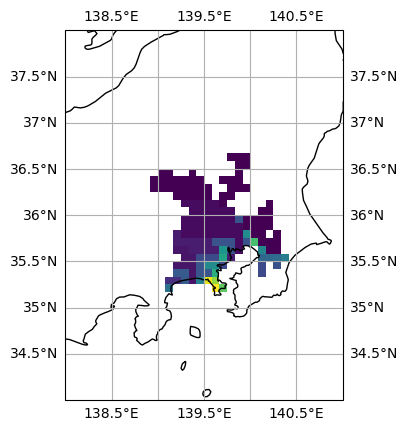

In [306]:
rivnum_tokyo_a = np.ma.masked_where(~np.isfinite(rivnum_tokyo_a) |  (rivnum_tokyo_a == 0), rivnum_tokyo_a)
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.coastlines()
ax.gridlines(draw_labels=True)
im = ax.imshow(rivnum_tokyo_a, extent=img_extent, transform=projection)

In [329]:
remove_basin_grid_threshold = 7

In [330]:
newdtype = [('rivara', 'float32'), ('rivnum', 'float32')]
aranum_cropped = np.empty(rivara_cropped.shape, dtype=newdtype)
aranum_cropped['rivara'] = rivara_cropped
aranum_cropped['rivnum'] = rivnum_cropped
rivnum_cropped_masked = np.ma.masked_array(aranum_cropped['rivnum'], np.isnan(aranum_cropped['rivnum']))
unique_values, counts = np.unique(rivnum_cropped_masked.compressed(), return_counts=True)
value_counts_dict = dict(zip(unique_values, counts))
sorted_dict_by_value_descending = dict(sorted(value_counts_dict.items(), key=lambda item: item[1], reverse=True))
filtered_dict = {key: value for key, value in sorted_dict_by_value_descending.items() if value >= remove_basin_grid_threshold}
rivnum_tokyo_b = np.ma.masked_all(rivnum_cropped.shape, dtype=dtype)
for rivnum_id in filtered_dict.keys():
    matching_positions = np.where(rivnum_tokyo_a.data == rivnum_id)
    rivnum_tokyo_b[matching_positions] = rivnum_id

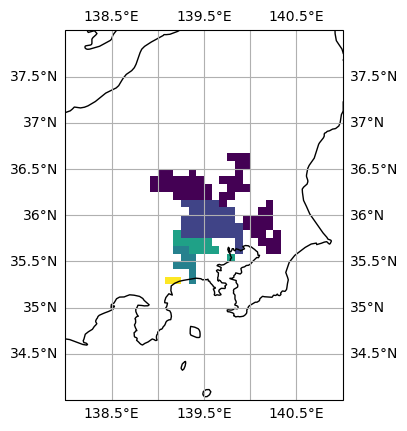

In [331]:
rivnum_tokyo_b = np.ma.masked_where(~np.isfinite(rivnum_tokyo_b) | (rivnum_tokyo_b == 0), rivnum_tokyo_b)
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.coastlines()
ax.gridlines(draw_labels=True)
im = ax.imshow(rivnum_tokyo_b, extent=img_extent, transform=projection)

In [332]:
unique_ids = np.unique(rivnum_tokyo_b.compressed())
rivnum_unique = np.ma.masked_all(rivnum_cropped_masked.shape, dtype='float32')
for uid in unique_ids:
    row_indices, col_indices = np.where(rivnum_cropped == uid)
    rivnum_unique[row_indices, col_indices] = uid

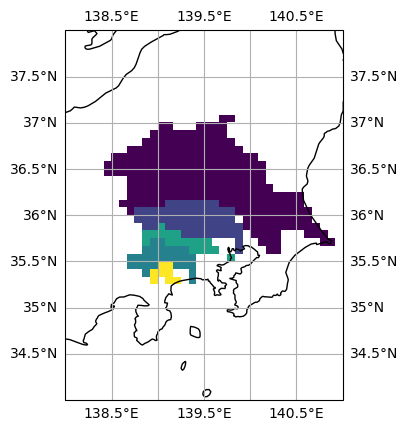

In [333]:
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.coastlines()
ax.gridlines(draw_labels=True)
im = ax.imshow(rivnum_unique, extent=img_extent, transform=projection)